<a href="https://colab.research.google.com/github/jasonbuchanan145/Data-Modeling/blob/main/insplad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# Define the path to the dataset
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/insplad'
base_path = f'{root_path}/defect_supervised'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
from typing import Tuple
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image, ImageDraw, ImageFont
import torchvision.ops.boxes as box_ops

In [39]:
class InsPLADDataset(Dataset):
    def __init__(self, root_dir: str, split: str = 'train', transform=None, class_to_idx=None):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.samples = []

        # Initialize dictionaries for class mappings
        if class_to_idx is None:
            self._build_class_mapping()
        else:
            self.hierarchical_class_to_idx = class_to_idx
            self.idx_to_hierarchical_class = {idx: class_name for class_name, idx in class_to_idx.items()}

        self._parse_directory()

    def _build_class_mapping(self):
        self.hierarchical_class_to_idx = {}
        self.idx_to_hierarchical_class = {}
        global_idx = 0

        for main_class in os.listdir(self.root_dir):
            main_class_dir = os.path.join(self.root_dir, main_class)
            if not os.path.isdir(main_class_dir):
                continue

            for split in ['train', 'val']:
                split_dir = os.path.join(main_class_dir, split)
                if not os.path.exists(split_dir):
                    continue

                for subclass in os.listdir(split_dir):
                    subclass_dir = os.path.join(split_dir, subclass)
                    if not os.path.isdir(subclass_dir):
                        continue

                    hierarchical_key = f"{main_class} - {subclass}"
                    if hierarchical_key not in self.hierarchical_class_to_idx:
                        self.hierarchical_class_to_idx[hierarchical_key] = global_idx
                        self.idx_to_hierarchical_class[global_idx] = hierarchical_key
                        global_idx += 1

    def _parse_directory(self):
        self.samples = []
        for main_class in os.listdir(self.root_dir):
            main_class_dir = os.path.join(self.root_dir, main_class)
            if not os.path.isdir(main_class_dir):
                continue

            split_dir = os.path.join(main_class_dir, self.split)
            if not os.path.exists(split_dir):
                continue

            for subclass in os.listdir(split_dir):
                subclass_dir = os.path.join(split_dir, subclass)
                if not os.path.isdir(subclass_dir):
                    continue

                hierarchical_key = f"{main_class} - {subclass}"

                for img_name in os.listdir(subclass_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(subclass_dir, img_name)
                        self.samples.append({
                            'path': img_path,
                            'main_class': main_class,
                            'subclass': subclass,
                            'hierarchical_class': hierarchical_key,
                            'class_idx': self.hierarchical_class_to_idx[hierarchical_key]
                        })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample['path']).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Extract main class index
        main_class = sample['main_class']
        main_class_idx = list(set(s['main_class'] for s in self.samples)).index(main_class)

        return image, main_class_idx, sample['class_idx']

    def get_class_distributions(self):
        """Calculate detailed distribution of samples across classes and subclasses."""
        from collections import Counter

        # Get main classes and their counts
        main_classes = [sample['main_class'] for sample in self.samples]
        main_class_counts = Counter(main_classes)

        # Get hierarchical distributions
        hierarchical_dist = {}
        for sample in self.samples:
            main_class = sample['main_class']
            subclass = sample['subclass']

            if main_class not in hierarchical_dist:
                hierarchical_dist[main_class] = {}
            if subclass not in hierarchical_dist[main_class]:
                hierarchical_dist[main_class][subclass] = 0
            hierarchical_dist[main_class][subclass] += 1

        return {
            'num_main_classes': len(set(main_classes)),
            'num_total_subclasses': len(self.hierarchical_class_to_idx),
            'main_classes': sorted(set(main_classes)),
            'class_distributions': {
                'main_classes': main_class_counts,
                'hierarchical': hierarchical_dist
            }
        }

In [40]:
# Data augmentation and preprocessing
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [41]:
class TwoHeadModel(nn.Module):
    def __init__(self, num_main_classes, num_hierarchical_subclasses):
        super().__init__()

        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet = resnet  # Keep the entire ResNet model

        # Replace the final fully connected layer for the main classifier
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_main_classes)

        # Define the Transformer Encoder and subclass classifier
        encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

        self.subclass_classifier = nn.Linear(512, num_hierarchical_subclasses)

    def forward(self, x, mode='main'):

        # Pass through the ResNet convolutional layers
        x_conv = self.resnet.conv1(x)
        x_conv = self.resnet.bn1(x_conv)
        x_conv = self.resnet.relu(x_conv)
        x_conv = self.resnet.maxpool(x_conv)

        x_conv = self.resnet.layer1(x_conv)
        x_conv = self.resnet.layer2(x_conv)
        x_conv = self.resnet.layer3(x_conv)
        x_conv = self.resnet.layer4(x_conv)

        # Main classifier forward pass
        x_pooled = self.resnet.avgpool(x_conv)
        x_flat = torch.flatten(x_pooled, 1)
        main_output = self.resnet.fc(x_flat)
        if mode == 'main':
          return main_output
        # Prepare for Transformer Encoder
        batch_size = x_conv.size(0)
        x_spatial = x_conv.view(batch_size, 512, -1).permute(0, 2, 1)

        x_attention = self.transformer_encoder(x_spatial)

        # Aggregate Transformer outputs
        x_attention_pooled = x_attention.mean(dim=1)

        # Subclass classifier forward pass
        subclass_output = self.subclass_classifier(x_attention_pooled)
        if mode == 'both':
            return main_output, subclass_output
        else:
            return subclass_output


In [42]:

def print_dataset_statistics(dataset):
    """Print dataset statistics using PrettyTable with desired format."""
    info = dataset.get_class_distributions()
    distributions = info['class_distributions']

    # Create summary table
    summary_table = PrettyTable()
    summary_table.field_names = ["Metric", "Value"]
    summary_table.align["Metric"] = "l"
    summary_table.align["Value"] = "r"

    total_images = len(dataset)
    summary_table.add_rows([
        ["Total Images", total_images],
        ["Main Classes", info['num_main_classes']],
        ["Total Subclasses", info['num_total_subclasses']]
    ])

    # Print first table with custom title
    print("+" + "-" * 26 + "+")
    print("|  Dataset Summary          |")
    print(summary_table)

    # Create distribution table
    dist_table = PrettyTable()
    dist_table.field_names = ["Main Class", "Subclass", "Images", "% of Class", "% of Total"]

    # Set alignment for each column
    dist_table.align["Main Class"] = "l"
    dist_table.align["Subclass"] = "l"
    dist_table.align["Images"] = "r"
    dist_table.align["% of Class"] = "r"
    dist_table.align["% of Total"] = "r"

    # Process each main class
    for main_class in sorted(info['main_classes']):
        main_class_count = distributions['main_classes'][main_class]
        subclasses = sorted(distributions['hierarchical'][main_class].keys())

        # Add rows for each subclass
        for i, subclass in enumerate(subclasses):
            subclass_count = distributions['hierarchical'][main_class][subclass]
            class_percentage = (subclass_count / main_class_count * 100)
            total_percentage = (subclass_count / total_images * 100)

            dist_table.add_row([
                main_class if i == 0 else "",  # Only show main class name for first subclass
                subclass,
                subclass_count,
                f"{class_percentage:.1f}%",
                f"{total_percentage:.1f}%"
            ])

        # Add separator after each main class (except the last one)
        if main_class != sorted(info['main_classes'])[-1]:
            dist_table.add_row(["-" * 31 if main_class != "" else "",
                              "-" * 11, "-" * 6, "-" * 8, "-" * 8])

    # Print second table with custom title
    print("\n+" + "-" * 82 + "+")
    print("|" + " " * 32 + "Class Distribution" + " " * 32 + "|")
    print(dist_table)

In [43]:
# Initialize the training dataset
train_dataset = InsPLADDataset(root_dir=base_path, split='train', transform=train_transform)

# Initialize the validation dataset
val_dataset = InsPLADDataset(root_dir=base_path, split='val', transform=val_transform)

# Create data loaders without performing internal splits
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2)
print_dataset_statistics(train_dataset)
print_dataset_statistics(val_dataset)


+--------------------------+
|  Dataset Summary          |
+------------------+-------+
| Metric           | Value |
+------------------+-------+
| Total Images     |  5108 |
| Main Classes     |     5 |
| Total Subclasses |    11 |
+------------------+-------+

+----------------------------------------------------------------------------------+
|                                Class Distribution                                |
+---------------------------------+-------------+--------+------------+------------+
| Main Class                      | Subclass    | Images | % of Class | % of Total |
+---------------------------------+-------------+--------+------------+------------+
| glass-insulator                 | good        |    691 |      50.0% |      13.5% |
|                                 | missing-cap |    690 |      50.0% |      13.5% |
| ------------------------------- | ----------- | ------ |   -------- |   -------- |
| lightning-rod-suspension        | good        |    348 

In [44]:
class HierarchicalClassifier:
    def __init__(self, device: torch.device):
        self.device = device
        self.model = None

    def create_model(self, train_loader):
        dataset = train_loader.dataset
        main_classes = set(sample['main_class'] for sample in dataset.samples)
        num_main_classes = len(main_classes)

        # Get total number of subclasses from the hierarchical mapping
        num_hierarchical_subclasses = len(dataset.hierarchical_class_to_idx)

        self.model = TwoHeadModel(num_main_classes, num_hierarchical_subclasses)
        self.model.to(self.device)

In [45]:
classifier = HierarchicalClassifier('cuda')
classifier.create_model(train_loader)

def freeze_resnet_layers(model, unfreeze_layers=None):
    """Freeze ResNet layers except for the specified layers to fine-tune."""
    for name, param in model.resnet.named_parameters():
        param.requires_grad = False
        # Unfreeze specified layers
        if unfreeze_layers and any(layer in name for layer in unfreeze_layers):
            param.requires_grad = True
    print("Layers frozen, except: ", unfreeze_layers)
freeze_resnet_layers(classifier.model, unfreeze_layers=['layer3', 'layer4'])


def train_fine_tuning_phase(classifier, train_loader, val_loader, num_epochs=5):
    """
    Train model with fine-tuning, validation metrics, and model checkpointing.
    Returns the best model based on validation performance.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier.model.parameters()), lr=0.005)

    best_val_loss = float('inf')
    best_model_state = None

    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        classifier.model.train()
        running_train_loss = 0.0
        for batch in train_loader:
            images, main_labels = batch[0], batch[1]  # Access first two elements of batch
            images, main_labels = images.to(device), main_labels.to(device)
            optimizer.zero_grad()
            outputs = classifier.model(images, mode='main')
            loss = criterion(outputs, main_labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        classifier.model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                images, main_labels = batch[0], batch[1]  # Access first two elements of batch
                images, main_labels = images.to(device), main_labels.to(device)
                outputs = classifier.model(images, mode='main')
                val_loss = criterion(outputs, main_labels)
                running_val_loss += val_loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = classifier.model.state_dict().copy()
            print(f"New best model saved!")
        print("-" * 50)

    # Plot training vs validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Load best model
    classifier.model.load_state_dict(best_model_state)
    return classifier



Layers frozen, except:  ['layer3', 'layer4']


In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# classifier = train_fine_tuning_phase(classifier, train_loader, val_loader, num_epochs=10)

In [47]:
for name, param in classifier.model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

resnet.conv1.weight: requires_grad = False
resnet.bn1.weight: requires_grad = False
resnet.bn1.bias: requires_grad = False
resnet.layer1.0.conv1.weight: requires_grad = False
resnet.layer1.0.bn1.weight: requires_grad = False
resnet.layer1.0.bn1.bias: requires_grad = False
resnet.layer1.0.conv2.weight: requires_grad = False
resnet.layer1.0.bn2.weight: requires_grad = False
resnet.layer1.0.bn2.bias: requires_grad = False
resnet.layer1.1.conv1.weight: requires_grad = False
resnet.layer1.1.bn1.weight: requires_grad = False
resnet.layer1.1.bn1.bias: requires_grad = False
resnet.layer1.1.conv2.weight: requires_grad = False
resnet.layer1.1.bn2.weight: requires_grad = False
resnet.layer1.1.bn2.bias: requires_grad = False
resnet.layer2.0.conv1.weight: requires_grad = False
resnet.layer2.0.bn1.weight: requires_grad = False
resnet.layer2.0.bn1.bias: requires_grad = False
resnet.layer2.0.conv2.weight: requires_grad = False
resnet.layer2.0.bn2.weight: requires_grad = False
resnet.layer2.0.bn2.bias:

In [48]:
class JointLoss(nn.Module):
    def __init__(self, alpha):
        super(JointLoss, self).__init__()
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, main_output, subclass_output, main_target, subclass_target):
        main_loss = self.criterion(main_output, main_target)
        subclass_loss = self.criterion(subclass_output, subclass_target)
        total_loss = self.alpha * main_loss + (1 - self.alpha) * subclass_loss
        return total_loss, main_loss, subclass_loss

# Using the joint loss during training
joint_loss = JointLoss(alpha=0.4)
optimizer = optim.Adam(classifier.model.parameters(), lr=0.001)

In [49]:
def train_joint_model(classifier, train_loader, val_loader, alpha=0.6, num_epochs=20, lr=0.001):
    """
    Train model with joint loss, validation metrics, and model checkpointing.
    Returns the best model based on validation performance.
    """
    joint_loss = JointLoss(alpha=alpha)
    optimizer = optim.Adam(classifier.model.parameters(), lr=lr)

    best_val_loss = float('inf')
    best_model_state = None

    # Lists to store metrics for plotting
    train_losses = {'total': [], 'main': [], 'subclass': []}
    val_losses = {'total': [], 'main': [], 'subclass': []}

    for epoch in range(num_epochs):
        # Training phase
        classifier.model.train()
        running_train_losses = {'total': 0.0, 'main': 0.0, 'subclass': 0.0}

        for images, main_labels, subclass_labels in train_loader:
            images = images.to(device)
            main_labels = main_labels.to(device)
            subclass_labels = subclass_labels.to(device)

            optimizer.zero_grad()
            main_outputs, subclass_outputs = classifier.model(images, mode='both')
            total_loss, main_loss, subclass_loss = joint_loss(
                main_outputs, subclass_outputs, main_labels, subclass_labels
            )

            total_loss.backward()
            optimizer.step()

            # Accumulate batch losses
            running_train_losses['total'] += total_loss.item()
            running_train_losses['main'] += main_loss.item()
            running_train_losses['subclass'] += subclass_loss.item()

        # Calculate average training losses
        for key in running_train_losses:
            avg_loss = running_train_losses[key] / len(train_loader)
            train_losses[key].append(avg_loss)

        # Validation phase
        classifier.model.eval()
        running_val_losses = {'total': 0.0, 'main': 0.0, 'subclass': 0.0}

        with torch.no_grad():
            for images, main_labels, subclass_labels in val_loader:
                images = images.to(device)
                main_labels = main_labels.to(device)
                subclass_labels = subclass_labels.to(device)

                main_outputs, subclass_outputs = classifier.model(images, mode='both')
                total_loss, main_loss, subclass_loss = joint_loss(
                    main_outputs, subclass_outputs, main_labels, subclass_labels
                )

                # Accumulate batch losses
                running_val_losses['total'] += total_loss.item()
                running_val_losses['main'] += main_loss.item()
                running_val_losses['subclass'] += subclass_loss.item()

        # Calculate average validation losses
        for key in running_val_losses:
            avg_loss = running_val_losses[key] / len(val_loader)
            val_losses[key].append(avg_loss)

        # Print epoch results
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Training Losses - Total: {train_losses['total'][-1]:.4f}, "
              f"Main: {train_losses['main'][-1]:.4f}, "
              f"Subclass: {train_losses['subclass'][-1]:.4f}")
        print(f"Validation Losses - Total: {val_losses['total'][-1]:.4f}, "
              f"Main: {val_losses['main'][-1]:.4f}, "
              f"Subclass: {val_losses['subclass'][-1]:.4f}")

        # Save best model based on total validation loss
        if val_losses['total'][-1] < best_val_loss:
            best_val_loss = val_losses['total'][-1]
            best_model_state = classifier.model.state_dict().copy()
            print("New best model saved!")
        print("-" * 50)

    # Plot training and validation losses
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot total losses
    ax1.plot(range(1, num_epochs + 1), train_losses['total'], label='Training Total Loss', marker='o')
    ax1.plot(range(1, num_epochs + 1), val_losses['total'], label='Validation Total Loss', marker='o')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Total Loss')
    ax1.set_title('Total Training vs Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot component losses
    for loss_type in ['main', 'subclass']:
        ax2.plot(range(1, num_epochs + 1), train_losses[loss_type],
                label=f'Training {loss_type.capitalize()} Loss', marker='o')
        ax2.plot(range(1, num_epochs + 1), val_losses[loss_type],
                label=f'Validation {loss_type.capitalize()} Loss', marker='o')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Component Losses')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Load best model
    classifier.model.load_state_dict(best_model_state)
    return classifier


Epoch 1/20
Training Losses - Total: 0.6359, Main: 0.3890, Subclass: 0.6977
Validation Losses - Total: 0.4688, Main: 0.0458, Subclass: 0.5746
New best model saved!
--------------------------------------------------

Epoch 2/20
Training Losses - Total: 0.2182, Main: 0.1323, Subclass: 0.2397
Validation Losses - Total: 0.1998, Main: 0.0424, Subclass: 0.2391
New best model saved!
--------------------------------------------------

Epoch 3/20
Training Losses - Total: 0.1551, Main: 0.0998, Subclass: 0.1689
Validation Losses - Total: 0.2162, Main: 0.0550, Subclass: 0.2565
--------------------------------------------------

Epoch 4/20
Training Losses - Total: 0.1521, Main: 0.0932, Subclass: 0.1668
Validation Losses - Total: 0.2307, Main: 0.1156, Subclass: 0.2595
--------------------------------------------------

Epoch 5/20
Training Losses - Total: 0.1299, Main: 0.0812, Subclass: 0.1420
Validation Losses - Total: 0.1345, Main: 0.0276, Subclass: 0.1612
New best model saved!
--------------------

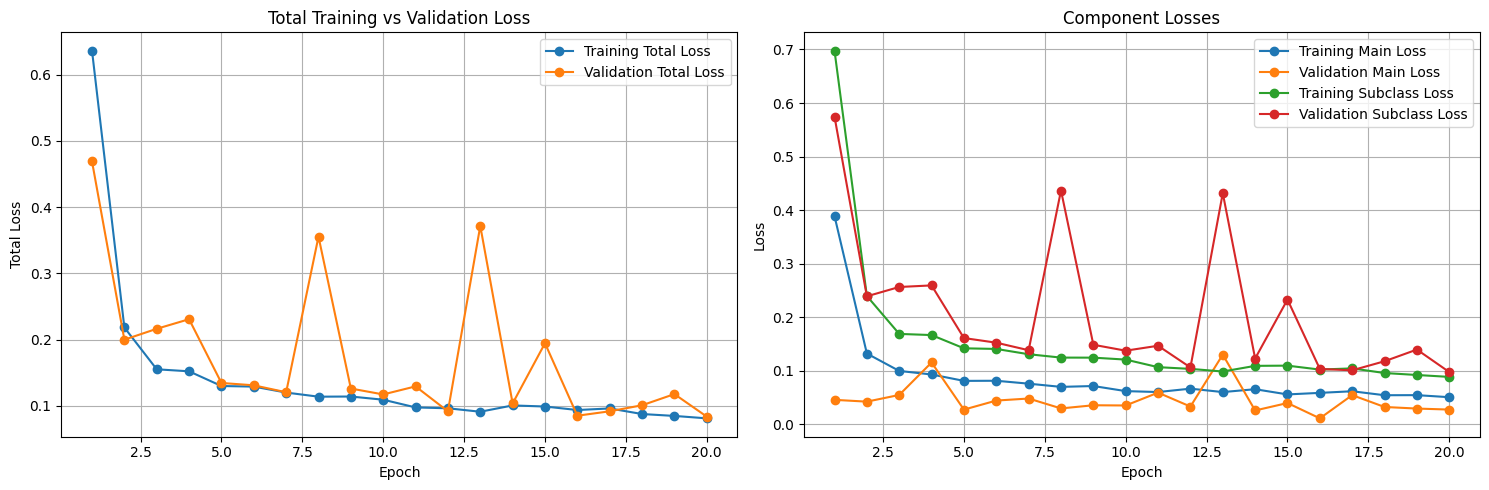

In [50]:
classifier = train_joint_model(
    classifier,
    train_loader,
    val_loader,
    alpha=0.2,
    num_epochs=20,
    lr=0.001
)

In [53]:
def evaluate_model(classifier, val_loader):
    classifier.model.eval()
    all_main_preds, all_main_labels = [], []
    all_subclass_preds, all_subclass_labels = [], []

    with torch.no_grad():
        for images, main_labels, subclass_labels in val_loader:
            images = images.to(device)
            main_labels = main_labels.to(device)
            subclass_labels = subclass_labels.to(device)

            # Get model predictions
            main_outputs, subclass_outputs = classifier.model(images, mode='both')
            _, main_predicted = torch.max(main_outputs.data, 1)
            _, subclass_predicted = torch.max(subclass_outputs.data, 1)

            # Store predictions and labels
            all_main_preds.extend(main_predicted.cpu().numpy())
            all_main_labels.extend(main_labels.cpu().numpy())
            all_subclass_preds.extend(subclass_predicted.cpu().numpy())
            all_subclass_labels.extend(subclass_labels.cpu().numpy())

    # Convert to numpy arrays for easier handling
    all_main_preds = np.array(all_main_preds)
    all_main_labels = np.array(all_main_labels)
    all_subclass_preds = np.array(all_subclass_preds)
    all_subclass_labels = np.array(all_subclass_labels)

    # Get main class names
    dataset = val_loader.dataset
    main_class_names = sorted(set(sample['main_class'] for sample in dataset.samples))

    # Get hierarchical class names
    subclass_names = [dataset.idx_to_hierarchical_class[i] for i in range(len(dataset.hierarchical_class_to_idx))]

    # Main class metrics and visualization
    print("\nMain Class Classification Report:")
    print(classification_report(all_main_labels, all_main_preds,
                              target_names=main_class_names, digits=3))

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_main_labels, all_main_preds)
    print(f"\nOverall Main Class Accuracy: {overall_accuracy:.3f}")

    # Confusion matrix for main classes
    main_conf_matrix = confusion_matrix(all_main_labels, all_main_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(main_conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=main_class_names, yticklabels=main_class_names)
    plt.title("Main Class Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Subclass evaluation
    print("\nHierarchical Subclass Classification Report:")
    print(classification_report(all_subclass_labels, all_subclass_preds,
                              target_names=subclass_names, digits=3))

    # Calculate overall subclass accuracy
    subclass_accuracy = accuracy_score(all_subclass_labels, all_subclass_preds)
    print(f"\nOverall Subclass Accuracy: {subclass_accuracy:.3f}")

    # Confusion matrix for subclasses
    subclass_conf_matrix = confusion_matrix(all_subclass_labels, all_subclass_preds)
    plt.figure(figsize=(15, 12))
    sns.heatmap(subclass_conf_matrix, annot=True, fmt='d', cmap='Greens',
                xticklabels=subclass_names, yticklabels=subclass_names)
    plt.title("Hierarchical Subclass Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return {
        'main_accuracy': overall_accuracy,
        'subclass_accuracy': subclass_accuracy,
        'main_conf_matrix': main_conf_matrix,
        'subclass_conf_matrix': subclass_conf_matrix
    }


Main Class Classification Report:
                                 precision    recall  f1-score   support

                glass-insulator      0.977     1.000     0.988       251
       lightning-rod-suspension      1.000     0.978     0.989       270
polymer-insulator-upper-shackle      0.996     1.000     0.998       281
                      vari-grip      1.000     1.000     1.000        59
                yoke-suspension      1.000     0.984     0.992        64

                       accuracy                          0.992       925
                      macro avg      0.995     0.992     0.993       925
                   weighted avg      0.993     0.992     0.992       925


Overall Main Class Accuracy: 0.992


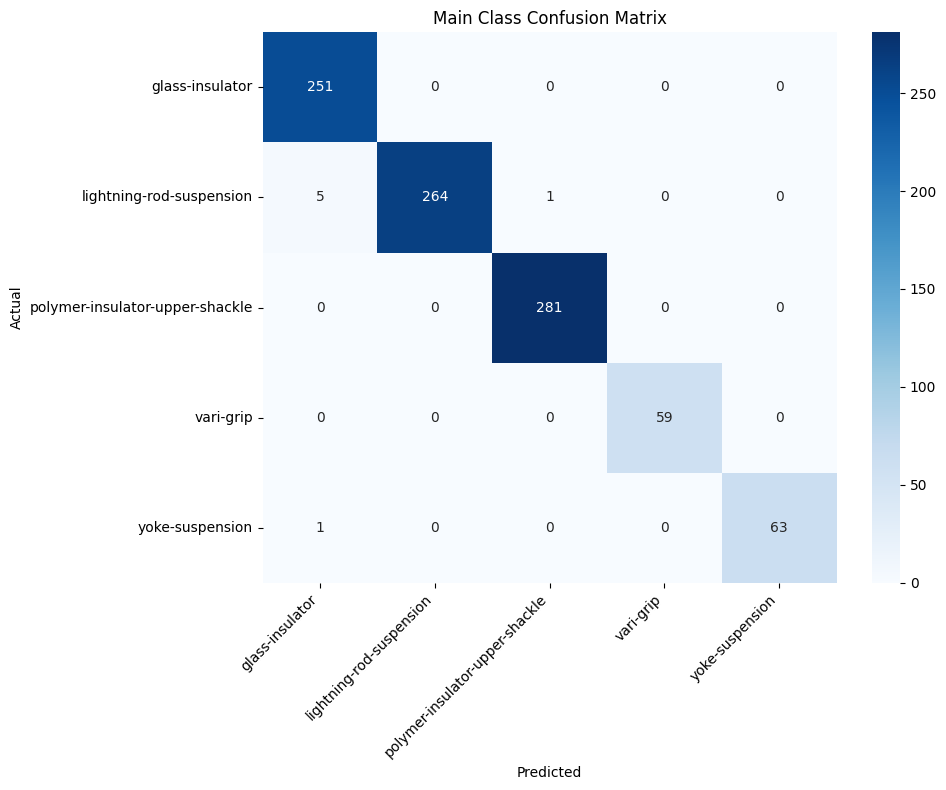


Hierarchical Subclass Classification Report:
                                        precision    recall  f1-score   support

                yoke-suspension - rust      1.000     0.800     0.889        20
                yoke-suspension - good      0.984     0.976     0.980       250
         glass-insulator - missing-cap      0.920     0.767     0.836        30
                glass-insulator - good      0.818     0.931     0.871        29
polymer-insulator-upper-shackle - rust      1.000     0.939     0.969        33
polymer-insulator-upper-shackle - good      0.967     0.935     0.951        31
       lightning-rod-suspension - good      0.975     1.000     0.987       231
       lightning-rod-suspension - rust      0.950     0.950     0.950        20
                      vari-grip - good      0.971     0.983     0.977       238
                 vari-grip - bird-nest      0.857     0.783     0.818        23
                      vari-grip - rust      0.870     1.000     0.930    

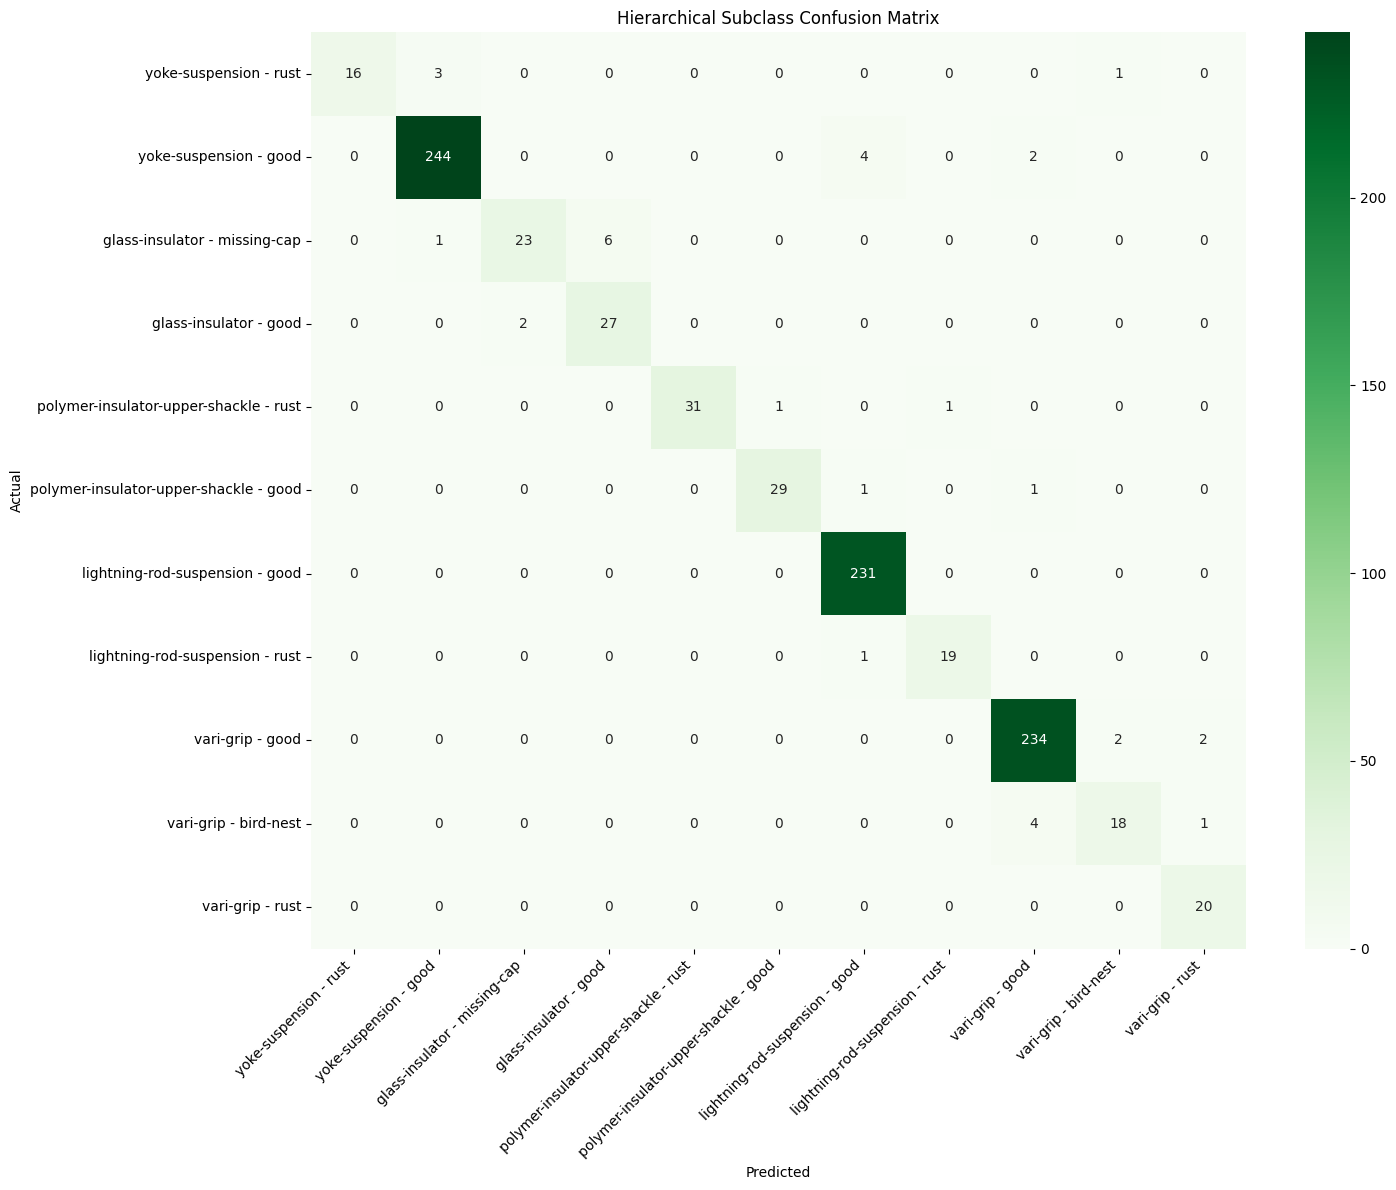

{'main_accuracy': 0.9924324324324324,
 'subclass_accuracy': 0.9643243243243244,
 'main_conf_matrix': array([[251,   0,   0,   0,   0],
        [  5, 264,   1,   0,   0],
        [  0,   0, 281,   0,   0],
        [  0,   0,   0,  59,   0],
        [  1,   0,   0,   0,  63]]),
 'subclass_conf_matrix': array([[ 16,   3,   0,   0,   0,   0,   0,   0,   0,   1,   0],
        [  0, 244,   0,   0,   0,   0,   4,   0,   2,   0,   0],
        [  0,   1,  23,   6,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   2,  27,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,  31,   1,   0,   1,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29,   1,   0,   1,   0,   0],
        [  0,   0,   0,   0,   0,   0, 231,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   1,  19,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 234,   2,   2],
        [  0,   0,   0,   0,   0,   0,   0,   0,   4,  18,   1],
        [  0,   0,   0,   0,   0,   0,   0,   0, 

In [54]:
evaluate_model(classifier, val_loader)

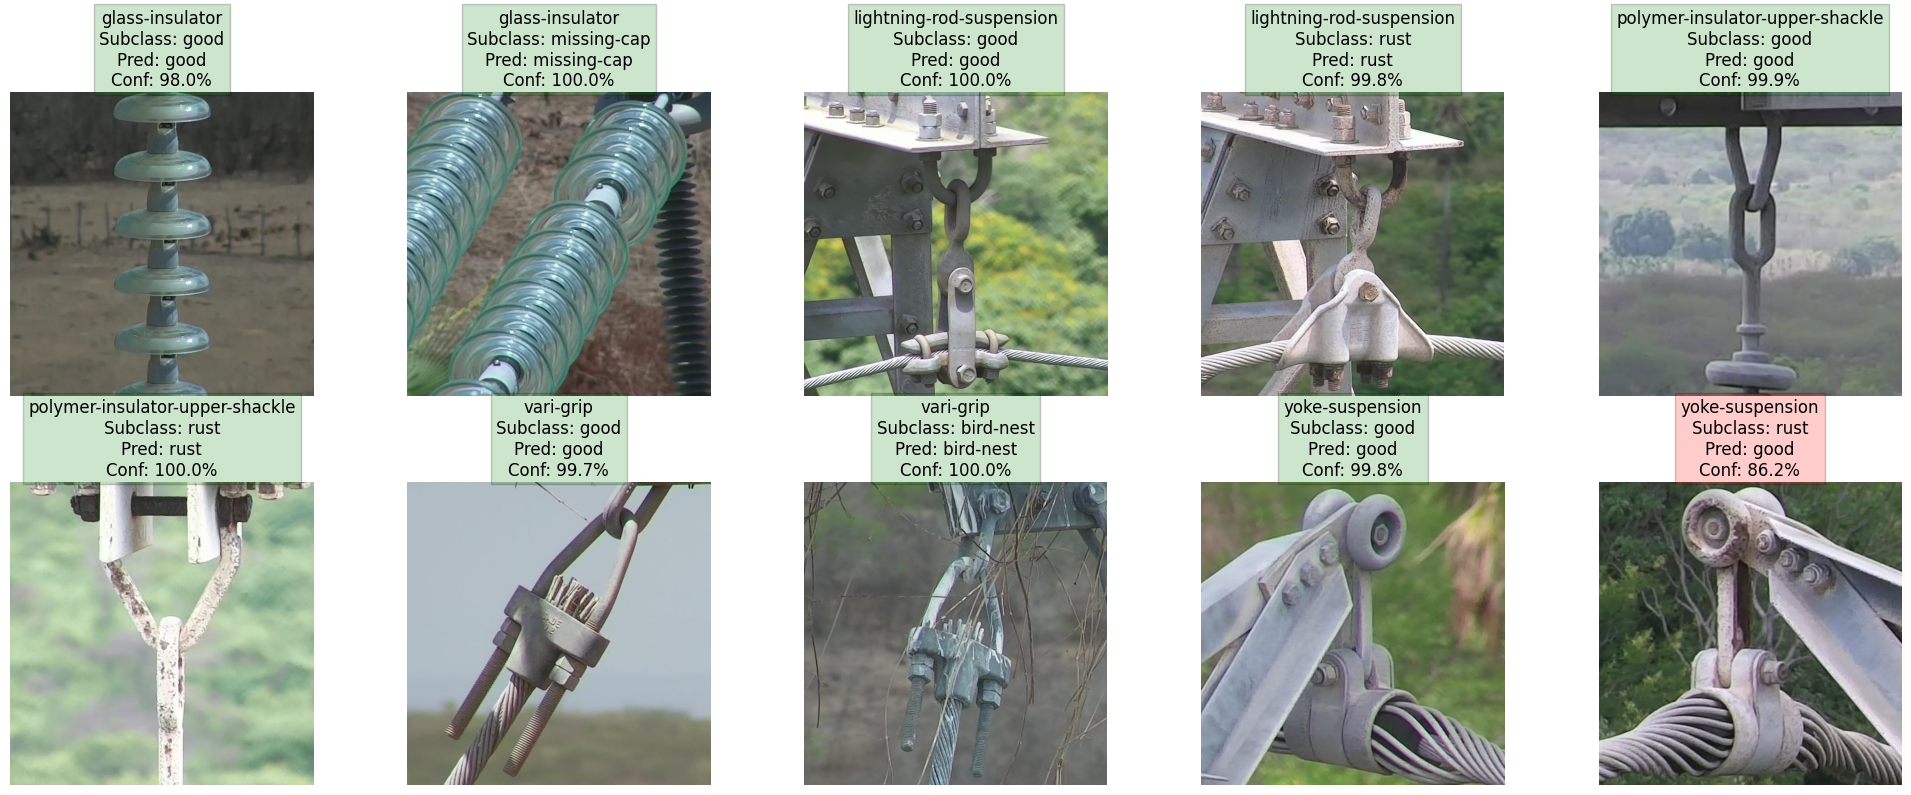


Classification Summary:
--------------------------------------------------
Good samples:
Samples shown: 5

Problematic samples:
Samples shown: 5


In [65]:
def demonstrate_hierarchical_classification_grid(model, val_dataset, device='cuda'):
    """
    Demonstrates the model's classification abilities by showing:
    1. One 'good' example from each main class
    2. One problematic example (non-good subclass) from each main class
    Displays results in a grid format.
    """
    model.eval()

    # Get unique main classes
    main_classes = sorted(set(sample['main_class'] for sample in val_dataset.samples))

    # Group samples by main class and subclass
    samples_by_class = {}
    for sample in val_dataset.samples:
        main_class = sample['main_class']
        subclass = sample['subclass']

        if main_class not in samples_by_class:
            samples_by_class[main_class] = {'good': [], 'other': []}

        if subclass == 'good':
            samples_by_class[main_class]['good'].append(sample)
        else:
            samples_by_class[main_class]['other'].append(sample)

    # Store results for good and problematic cases
    results = []

    # Get one good and one problematic sample for each main class
    for main_class in main_classes:
        # Get good sample
        if samples_by_class[main_class]['good']:
            good_sample = random.choice(samples_by_class[main_class]['good'])
            results.append(('good', good_sample))

        # Get problematic sample
        if samples_by_class[main_class]['other']:
            prob_sample = random.choice(samples_by_class[main_class]['other'])
            results.append(('problem', prob_sample))

    # Create figure with grid layout
    num_samples = len(results)
    ncols = 5
    nrows = (num_samples + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4*nrows))
    axes = axes.flatten()

    # Process each sample
    for idx, (sample_type, sample) in enumerate(results):
        if idx < len(axes):
            ax = axes[idx]

            # Load and process image
            image = Image.open(sample['path']).convert('RGB')
            if val_dataset.transform:
                image_tensor = val_dataset.transform(image).unsqueeze(0).to(device)

            # Get predictions
            with torch.no_grad():
                main_output, subclass_output = model(image_tensor, mode='both')

                # Get predictions and confidences
                main_probs = torch.softmax(main_output, dim=1)
                main_conf, main_pred = torch.max(main_probs, dim=1)

                subclass_probs = torch.softmax(subclass_output, dim=1)
                subclass_conf, subclass_pred = torch.max(subclass_probs, dim=1)

                # Get predicted class names
                pred_hierarchical = val_dataset.idx_to_hierarchical_class[subclass_pred.item()]
                pred_main_class = pred_hierarchical.split(' - ')[0]
                pred_subclass = pred_hierarchical.split(' - ')[1]

            # Display image
            ax.imshow(image)
            ax.axis('off')

            # Create title
            main_correct = pred_main_class == sample['main_class']
            subclass_correct = pred_subclass == sample['subclass']

            title = f"{sample['main_class']}\n"
            title += f"Subclass: {sample['subclass']}\n"
            title += f"Pred: {pred_subclass}\n"
            title += f"Conf: {subclass_conf.item():.1%}"

            # Color code based on correctness
            bbox_color = 'green' if (main_correct and subclass_correct) else 'red'
            ax.set_title(title, bbox=dict(facecolor=bbox_color, alpha=0.2), pad=5)

    # Remove empty subplots
    for idx in range(len(results), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nClassification Summary:")
    print("-" * 50)
    print("Good samples:")
    good_results = [r for r, s in results if r == 'good']
    print(f"Samples shown: {len(good_results)}")

    print("\nProblematic samples:")
    prob_results = [r for r, s in results if r == 'problem']
    print(f"Samples shown: {len(prob_results)}")

# Usage
demonstrate_hierarchical_classification_grid(classifier.model, val_dataset)

In [ ]:

def upscale_image(image, target_width=1500):
    """
    Upscale image while maintaining aspect ratio.
    """
    original_width, original_height = image.size
    scale_factor = target_width / original_width
    target_height = int(original_height * scale_factor)
    upscaled_image = image.resize((target_width, target_height), Image.Resampling.LANCZOS)
    return upscaled_image

def draw_detections(image, detections, idx_to_class=None, output_path=None):
    """
    Draw bounding boxes on upscaled image with larger text.
    """
    img_draw = image.copy()
    draw = ImageDraw.Draw(img_draw)

    # Increase font size significantly - now 3% of image width
    font_size = int(image.size[0] * 0.10)
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except:
        font = ImageFont.load_default()

    colors = {
        0: (0, 255, 0),    # Green
        1: (255, 0, 0),    # Red
        2: (0, 0, 255),    # Blue
        3: (255, 255, 0),  # Yellow
        4: (255, 0, 255)   # Magenta
    }

    # Increase border width
    border_width = max(6, int(image.size[0] * 0.004))

    for det in detections:
        bbox = [int(x) for x in det['bbox']]
        conf = det['confidence']
        class_idx = det['class']

        color = colors.get(class_idx, (255, 255, 255))

        # Draw thicker rectangle
        for i in range(border_width):
            draw.rectangle([
                bbox[0]-i, bbox[1]-i,
                bbox[2]+i, bbox[3]+i
            ], outline=color, width=3)

        # Prepare label
        class_name = f"Class {class_idx}" if idx_to_class is None else idx_to_class[class_idx]
        label = f"{class_name} ({conf:.2f})"

        # Increase text offset for larger text
        text_offset = int(image.size[1] * 0.05)
        text_bbox = draw.textbbox((bbox[0], max(0, bbox[1]-text_offset)),
                                label, font=font)

        # Make background box larger
        padding = font_size // 4
        text_bbox = (
            text_bbox[0] - padding,
            text_bbox[1] - padding,
            text_bbox[2] + padding,
            text_bbox[3] + padding
        )

        draw.rectangle(text_bbox, fill='black')
        draw.rectangle(text_bbox, outline=color, width=3)

        # Draw larger text
        draw.text((bbox[0], max(0, bbox[1]-text_offset)),
                 label, fill=color, font=font)

    if output_path:
        img_draw.save(output_path, quality=95)

    return img_draw

def detect_objects(model, image_path: str, window_size: tuple = (224, 224),
                  overlap: float = 0.25, confidence_threshold: float = 0.7,
                  target_width: int = 1000) -> tuple:
    """
    Object detection with sliding window and NMS.

    Args:
        model: PyTorch model for detection
        image_path: Path to input image
        window_size: Tuple of (height, width) for sliding window
        overlap: Overlap ratio between windows
        confidence_threshold: Minimum confidence score for detections
        target_width: Target width for image upscaling

    Returns:
        tuple: (final_detections, upscaled_image)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Load and upscale image
    image = Image.open(image_path).convert('RGB')
    original_size = image.size
    image = upscale_image(image, target_width=target_width)

    print(f"Original size: {original_size}")
    print(f"Upscaled size: {image.size}")
    print(f"Scale factor: {target_width/original_size[0]:.2f}")

    # Prepare transform for windows
    transform = transforms.Compose([
        transforms.Resize(window_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Calculate stride for sliding window
    stride = int(min(window_size) * (1 - overlap))
    width, height = image.size
    detections = []

    # Sliding window detection
    for y in range(0, height - window_size[1], stride):
        for x in range(0, width - window_size[0], stride):
            window = image.crop((x, y, x + window_size[0], y + window_size[1]))
            window_tensor = transform(window).unsqueeze(0).to(device)

            with torch.no_grad():
                try:
                    # Get both main and subclass predictions
                    main_output, subclass_output = model(window_tensor, mode='both')
                    subclass_probs = torch.softmax(subclass_output, dim=1)

                    confidence, predicted_class = torch.max(subclass_probs, dim=1)
                    confidence = confidence.item()
                    predicted_class = predicted_class.item()

                    if confidence > confidence_threshold:
                        detections.append({
                            'bbox': [float(x), float(y),
                                    float(x + window_size[0]),
                                    float(y + window_size[1])],
                            'confidence': confidence,
                            'class': predicted_class
                        })
                except Exception as e:
                    print(f"Error processing window at ({x}, {y}): {e}")
                    continue

    # Apply NMS per class
    final_detections = []
    if detections:
        class_detections = {}
        for det in detections:
            cls = det['class']
            if cls not in class_detections:
                class_detections[cls] = []
            class_detections[cls].append(det)

        for cls in class_detections:
            boxes = torch.tensor([d['bbox'] for d in class_detections[cls]],
                               dtype=torch.float32, device=device)
            scores = torch.tensor([d['confidence'] for d in class_detections[cls]],
                                dtype=torch.float32, device=device)

            keep = box_ops.nms(boxes, scores, iou_threshold=0.45)
            keep = keep.cpu()

            for idx in keep[:5]:  # Keep top 5 detections per class
                final_detections.append(class_detections[cls][idx])

    return final_detections, image

def detect_and_display(model, image_path: str, idx_to_class: dict = None,
                      output_path: str = None, target_width: int = 1500) -> Image:
    """

    Args:
        model: PyTorch model for detection
        image_path: Path to input image
        idx_to_class: Dictionary mapping class indices to names
        output_path: Path to save output image
        target_width: Target width for image upscaling

    Returns:
        PIL.Image: Annotated image with detections
    """
    print("Starting detection...")

    detections, upscaled_image = detect_objects(
        model=model,
        image_path=image_path,
        window_size=(224, 224),
        overlap=0.25,
        confidence_threshold=0.85,
        target_width=target_width
    )

    print(f"Found {len(detections)} objects")

    annotated_image = draw_detections(
        upscaled_image,
        detections,
        idx_to_class=idx_to_class,
        output_path=output_path
    )

    # Print detection results
    print("\nDetections (sorted by confidence):")
    sorted_detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
    for i, det in enumerate(sorted_detections, 1):
        class_name = f"Class {det['class']}" if idx_to_class is None else idx_to_class[det['class']]
        print(f"{i}. {class_name} with confidence {det['confidence']:.2f}")

    return annotated_image

idx_to_subclass = {idx: f"{main} - {sub}" for (main, sub), idx
                   in train_dataset.hierarchical_subclass_to_idx.items()}



for name in ['09-06-2021_DJI_0466_568.jpg','292-1_DJI_0158.jpg', '238-1_DJI_0383.jpg',
             'Fotos 01-12-2020_DJI_0020_amarra_balancim_337.jpg', '238-1_DJI_0386.jpg','01-06-2021_DJI_0352_107.jpg']:
    output_path = f'output_{name}'
    annotated_image = detect_and_display(
        model=classifier.model,
        image_path=f'drive/MyDrive/insplad/{name}',
        idx_to_class=idx_to_subclass,
        output_path=output_path,
        target_width=800
    )
    display(annotated_image)

